In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt

In [12]:
data = np.load("climbing_dataset.npz", allow_pickle=True)
X = data["X"]
y = data["y"]
names = data["names"]

In [13]:
class ClimbingCNNHybrid(nn.Module):
    def __init__(self, num_channels=6):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(num_channels, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        
        # 128 from CNN + 2 global (matching, angle)
        self.fc = nn.Sequential(
            nn.Linear(128 + 2, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x, global_feats):
        x = self.conv1(x)
        x_cnn = self.conv2(x)
        # Add residual connection: skip `conv2` and add `x`
        x_cnn = self.conv3(x_cnn) + x_cnn
        x_cnn = self.avg_pool(x_cnn)
        x_cnn = torch.flatten(x_cnn, 1)
        
        out = torch.cat([x_cnn, global_feats], dim=1)
        return self.fc(out)


In [14]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

X_cnn = X[:, :6, :]

global_feats = X[:, 6:, 0]  # shape (N, 2)

n_samples = X.shape[0]
train_size = int(0.8 * n_samples)
val_size = n_samples - train_size

dataset = TensorDataset(X_cnn, global_feats, y)
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ClimbingCNNHybrid().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [16]:
num_epochs = 100
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for Xb, gb, yb in train_dl:
        Xb, gb, yb = Xb.to(device), gb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(Xb, gb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * Xb.size(0)

    avg_train_loss = total_train_loss / len(train_dl.dataset)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1:02d} | Train Loss: { avg_train_loss:.4f}")

Epoch 01 | Train Loss: 322.5852
Epoch 02 | Train Loss: 46.8727
Epoch 03 | Train Loss: 18.9938
Epoch 04 | Train Loss: 16.4225
Epoch 05 | Train Loss: 15.2616
Epoch 06 | Train Loss: 14.5341
Epoch 07 | Train Loss: 13.6031
Epoch 08 | Train Loss: 12.7521
Epoch 09 | Train Loss: 12.7975
Epoch 10 | Train Loss: 12.3749
Epoch 11 | Train Loss: 12.0488
Epoch 12 | Train Loss: 11.8020
Epoch 13 | Train Loss: 11.6151
Epoch 14 | Train Loss: 11.3755
Epoch 15 | Train Loss: 12.4814
Epoch 16 | Train Loss: 11.9219
Epoch 17 | Train Loss: 11.2198
Epoch 18 | Train Loss: 10.8288
Epoch 19 | Train Loss: 11.1793
Epoch 20 | Train Loss: 11.4112
Epoch 21 | Train Loss: 10.8126
Epoch 22 | Train Loss: 11.1653
Epoch 23 | Train Loss: 10.6613
Epoch 24 | Train Loss: 10.3156
Epoch 25 | Train Loss: 10.9660
Epoch 26 | Train Loss: 10.8328
Epoch 27 | Train Loss: 10.6421
Epoch 28 | Train Loss: 10.1591
Epoch 29 | Train Loss: 9.9739
Epoch 30 | Train Loss: 10.4128
Epoch 31 | Train Loss: 10.1059
Epoch 32 | Train Loss: 10.3816
Epoch 33

In [17]:
model.eval()
total_val_loss = 0
with torch.no_grad():
    for Xb, gb, yb in val_dl:
        Xb, gb, yb = Xb.to(device), gb.to(device), yb.to(device)
        preds = model(Xb, gb)
        loss = criterion(preds, yb)
        total_val_loss += loss.item() * Xb.size(0)
avg_val_loss = total_val_loss / len(val_dl.dataset)
val_losses.append(avg_val_loss)

print(f"Epoch {epoch+1}/{num_epochs}  Train Loss: {avg_train_loss:.4f}  Val Loss: {avg_val_loss:.4f}")

Epoch 100/100  Train Loss: 6.6005  Val Loss: 19.3435


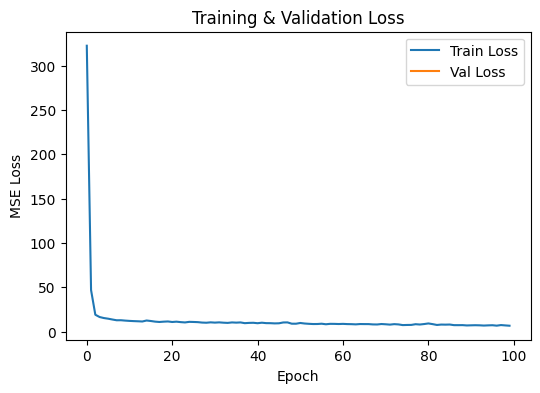

In [18]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()


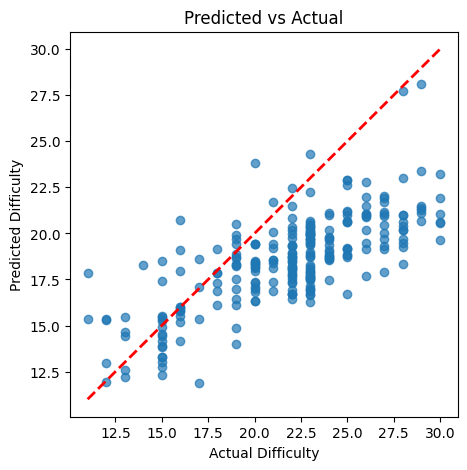

: 

In [ ]:
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for Xb, gb, yb in val_dl:
        Xb, gb = Xb.to(device), gb.to(device)
        preds = model(Xb, gb)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(yb.cpu().numpy())

y_pred = np.concatenate(all_preds).flatten()
y_true = np.concatenate(all_targets).flatten()

plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, alpha=0.7)
plt.plot([y_true.min(), y_true.max()],
         [y_true.min(), y_true.max()],
         'r--', lw=2)
plt.xlabel("Actual Difficulty")
plt.ylabel("Predicted Difficulty")
plt.title("Predicted vs Actual")
plt.show()